In [1]:
import mdtraj as md
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN

from funcs_validate_msm import *
from funcs_build_msm import get_data 
from natsort import natsorted
from pathlib import Path
from funcs_abl_featurise import *
#from funcs_egfr_featurise import *

In [2]:
protein = 'abl'
save_dir = Path(f'data_{protein}/plots/')
sample_dir = Path(f'data_{protein}/samples/')
cluster_dir = Path(f'data_{protein}/cluster_centers/')
cluster_dir.mkdir(exist_ok=True, parents=True)

crystal_files = natsorted([str(f) for f in Path(f"/arc/human_{protein}/").glob("kinoml*.pdb")])
crystal_dbdist = np.array([dbdist_featuriser(md.load(f)) for f in crystal_files]).squeeze()
crystal_dbdihed = np.array([dbdihed_featuriser(md.load(f)) for f in crystal_files]).squeeze()

In [3]:
f_dunbrack = natsorted([str(d) for d in Path(f'./data_{protein}/ftrajs/').glob('run*-clone*_dbdist.npy')])
dbdist, traj_mapping = get_data(trajlen_cutoff=1000, features=['dbdist'], ftraj_dir=Path(f'data_{protein}/ftrajs'))
dbdist_cat = np.concatenate(dbdist)
sliced_dbdist = dbdist_cat[::1000, 0:2]
sliced_dbdist.shape

Loading feature:  dbdist


  0%|          | 0/749 [00:00<?, ?it/s]

100%|██████████| 749/749 [00:03<00:00, 247.01it/s]

Loaded number of ftrajs: 416


(11707, 2)

Apply average linkage hierarchical clustering to classify DFG-in/out/inter conformations using a subset of data

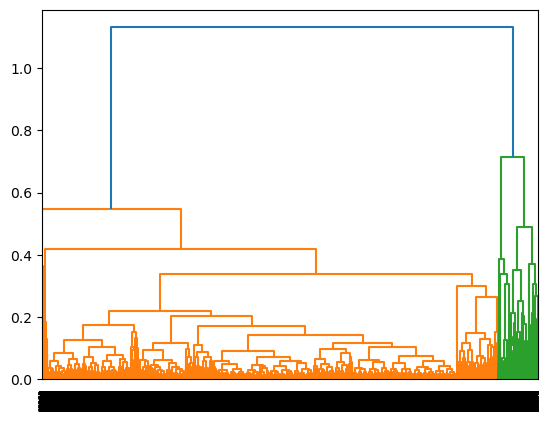

In [93]:
Z = linkage(sliced_dbdist[:, :2], method='average')
R = dendrogram(Z)
clusters = fcluster(Z, 3, criterion='maxclust')
clustered_data = [sliced_dbdist[clusters == i] for i in np.unique(clusters)]

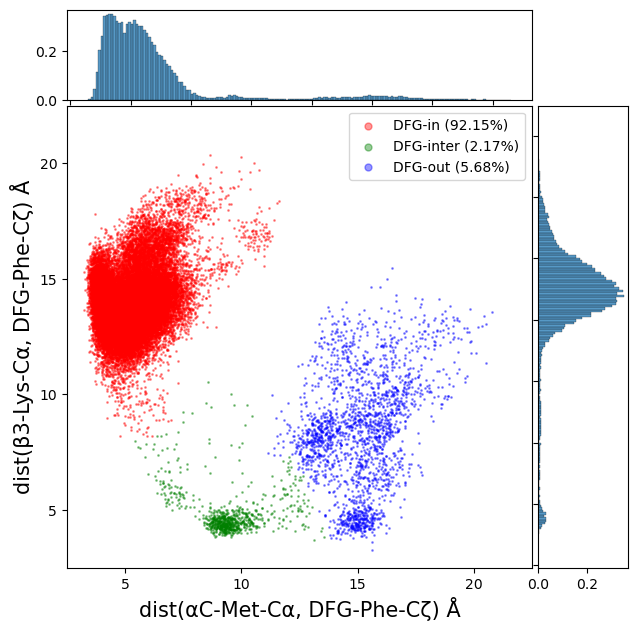

In [94]:
# Top left -- DFG-in
# Bottom right -- DFG-out
# Bottom -- DFG-inter

fig, ax = plt.subplots(figsize=(6, 6))
intx_ax = fig.add_axes([ax.get_position().x0, ax.get_position().y1 + 0.01,
                        ax.get_position().width, 0.15])
inty_ax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0,
                        0.15, ax.get_position().height])

ax.scatter(clustered_data[0][:,0]*10, clustered_data[0][:,1]*10, s=1, alpha=0.4, c='r', label=f'DFG-in ({len(clustered_data[0])/len(sliced_dbdist)*100:.2f}%)')
ax.scatter(clustered_data[1][:,0]*10, clustered_data[1][:,1]*10, s=1, alpha=0.4, c='g', label=f'DFG-inter ({len(clustered_data[1])/len(sliced_dbdist)*100:.2f}%)')
ax.scatter(clustered_data[2][:,0]*10, clustered_data[2][:,1]*10, s=1, alpha=0.4, c='b', label=f'DFG-out ({len(clustered_data[2])/len(sliced_dbdist)*100:.2f}%)')
ax.legend(markerscale=5)

sns.histplot(x=sliced_dbdist[:, 0]*10, stat='density', lw=3, ax=intx_ax)
sns.histplot(y=sliced_dbdist[:, 1]*10, stat='density', lw=3, ax=inty_ax)

ax.set_xlabel('dist(αC-Met-Cα, DFG-Phe-Cζ) Å', fontsize=15)
ax.set_ylabel('dist(β3-Lys-Cα, DFG-Phe-Cζ) Å', fontsize=15)
ax.set_xlim(2.5, 22.5)
ax.set_ylim(2.5, 22.5)
ax.set_xticks(np.arange(5, 25, 5))
ax.set_yticks(np.arange(5, 25, 5))
intx_ax.set_ylabel('')
intx_ax.tick_params(labelbottom=False)
inty_ax.set_xlabel('')
inty_ax.tick_params(labelleft=False)

plt.savefig(save_dir / 'dfg_dist_clusters.png', dpi=300, transparent=True)
plt.show()

In [97]:
centroids = np.array([np.mean(cluster, axis=0) for cluster in clustered_data])
centroids.dump(cluster_dir / 'dfg_spatial_centroids.npy')

Assign starting structures to DFG spatial groups

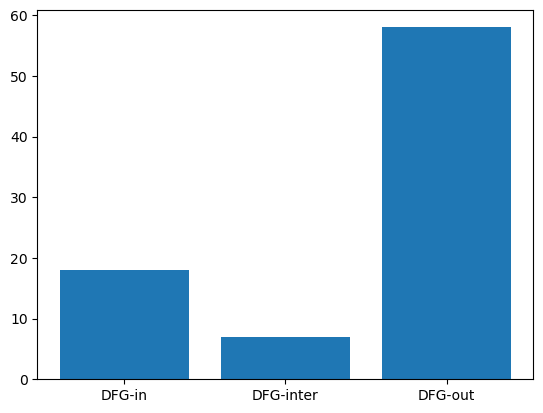

In [4]:
crystal_clusters = assign_dfg_spatial(crystal_dbdist)
fig, ax = plt.subplots()
ax.bar(['DFG-in', 'DFG-inter', 'DFG-out'], np.bincount(crystal_clusters))
plt.savefig(save_dir / 'dfg_dist_crystal_clusters.png', dpi=300, transparent=True)
plt.show()

Assign simulation data to DFG spatial groups

In [5]:
dfg_spatial_dtraj = assign_dfg_spatial(dbdist_cat)
dfgin = np.where(dfg_spatial_dtraj == 0)[0]
dfginter = np.where(dfg_spatial_dtraj == 1)[0]
dfgout = np.where(dfg_spatial_dtraj == 2)[0]

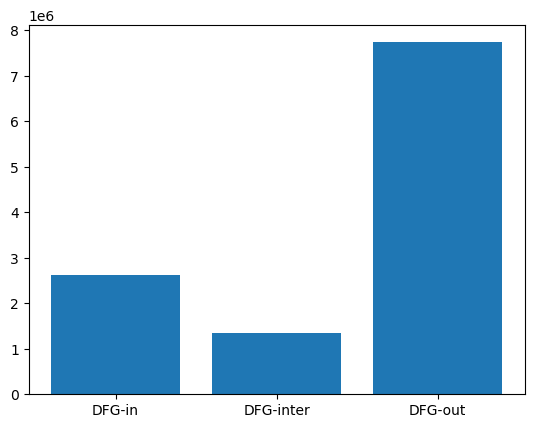

In [6]:
fig, ax = plt.subplots()
ax.bar(['DFG-in', 'DFG-inter', 'DFG-out'], np.bincount(dfg_spatial_dtraj))
plt.savefig(save_dir / 'dfg_dist_sim_clusters.png', dpi=300, transparent=True)
plt.show()

Assign simulation data (clusterd into spatial groups) to predefined cluster centroids

In [7]:
dbdihed, traj_mapping = get_data(trajlen_cutoff=1000, features=['dbdihed'], ftraj_dir=Path(f'data_{protein}/ftrajs'), msm=False)
dbdihed_cat = np.concatenate(dbdihed)
dfgin_dihed = dbdihed_cat[dfgin][::500, :]
dfginter_dihed = dbdihed_cat[dfginter][::250, :]
dfgout_dihed = dbdihed_cat[dfgout][::1600, :]

Loading feature:  dbdihed


  0%|          | 0/749 [00:00<?, ?it/s]

100%|██████████| 749/749 [00:04<00:00, 164.64it/s]


Loaded number of ftrajs: 416


In [8]:
in_dtraj = assign_dfg_dihed(dfgin_dihed[:, [0,1,2,3,4,5,8]], spatial_group='dfg-in', noise_cutoff=1)
np.unique(min, return_counts=True)

(array([<built-in function min>], dtype=object), array([1]))

In [9]:
out_dtraj = assign_dfg_dihed(dfgout_dihed[:, [0,1,2,3,4,5,8]], spatial_group='dfg-out', noise_cutoff=1)
np.unique(min, return_counts=True)

(array([<built-in function min>], dtype=object), array([1]))

In [10]:
inter_dtraj = assign_dfg_dihed(dfginter_dihed[:, [0,1,2,3,4,5,8]], spatial_group='dfg-inter', noise_cutoff=1)
np.unique(min, return_counts=True)

(array([<built-in function min>], dtype=object), array([1]))

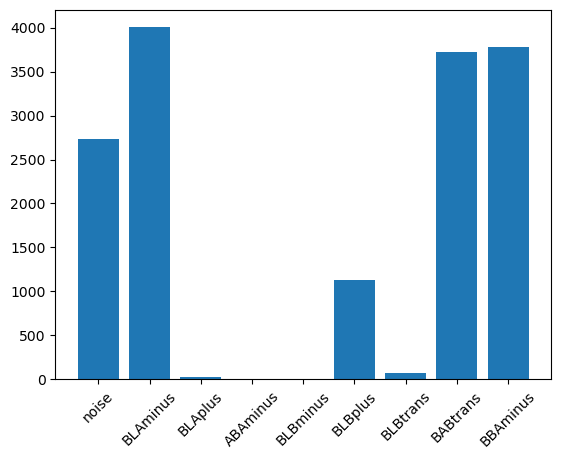

In [11]:
fig, ax = plt.subplots()
bincounts = [sum(in_dtraj==-1) + sum(inter_dtraj==-1) + sum(out_dtraj==-1),
             sum(in_dtraj==0),
             sum(in_dtraj==1),
             sum(in_dtraj==2),
             sum(in_dtraj==3),
             sum(in_dtraj==4),
             sum(in_dtraj==5),
             sum(inter_dtraj==0),
             sum(out_dtraj==0)]
cluster_labels = ['noise', 'BLAminus', 'BLAplus', 'ABAminus', 'BLBminus', 'BLBplus', 'BLBtrans', 'BABtrans', 'BBAminus']
ax.bar(cluster_labels, bincounts)
ax.xaxis.set_tick_params(rotation=45)
plt.show()

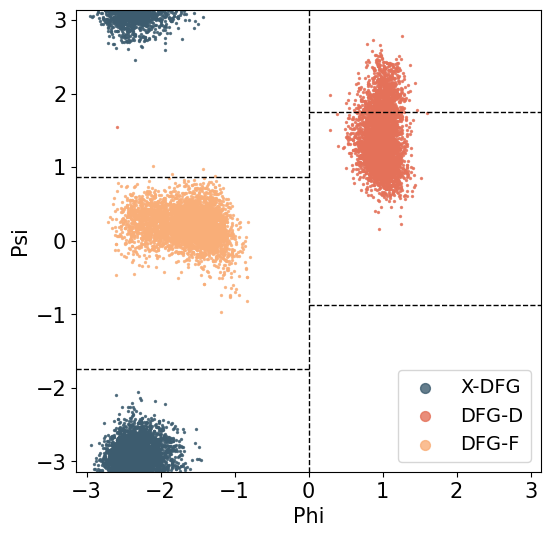

In [41]:
regions = {
    'B': {'phi': (-180, -90), 'psi': (90, 180)},
    'A': {'phi': (-90, 0), 'psi': (-60, 30)},
    'L': {'phi': (0, 180), 'psi': (0, 90)},
    'E': {'phi': (-180, -90), 'psi': (-180, -90)},
}

blaminus = np.where(in_dtraj == 0)[0]
blaminus_dihed = dfgin_dihed[blaminus]

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(blaminus_dihed[:, 0], blaminus_dihed[:, 1], s=2, alpha=0.8, c='#3D5C6F', label=f'X-DFG') 
ax.scatter(blaminus_dihed[:, 2], blaminus_dihed[:, 3], s=2, alpha=0.8, c='#E47159', label=f'DFG-Asp') 
ax.scatter(blaminus_dihed[:, 4], blaminus_dihed[:, 5], s=2, alpha=0.8, c='#F9AE78', label=f'DFG-PhE') 

ax.plot([0,0], [-np.pi, np.pi], c='k', lw=1, ls='--')
ax.plot([-np.pi, 0], [np.deg2rad(-100), np.deg2rad(-100)], c='k', lw=1, ls='--')
ax.plot([-np.pi, 0], [np.deg2rad(50), np.deg2rad(50)], c='k', lw=1, ls='--')
ax.plot([0, np.pi], [np.deg2rad(-50), np.deg2rad(-50)], c='k', lw=1, ls='--')
ax.plot([0, np.pi], [np.deg2rad(100), np.deg2rad(100)], c='k', lw=1, ls='--')

ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
ax.legend(markerscale=5, fontsize=14, loc='lower right')
ax.set_xlabel('Phi', fontsize=15)
ax.set_ylabel('Psi', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.savefig(save_dir / 'ramachandran_partition.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [13]:
in_dtraj.shape

(5245,)

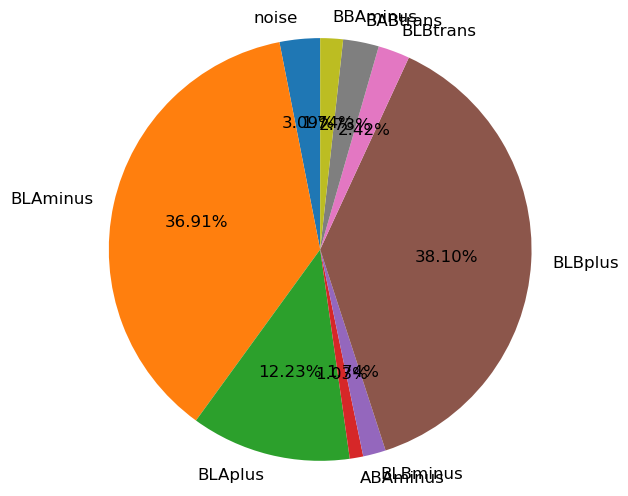

In [113]:
fig, ax = plt.subplots(figsize=(6, 6))

filtered_labels = [label if count/sum(bincounts) >= 0.01 else '' for label, count in zip(cluster_labels, bincounts)]

ax.pie(bincounts, labels=filtered_labels, autopct=lambda p: f'{p:.2f}%' if p >= 1 else '', startangle=90, textprops={'fontsize': 12})
ax.axis('equal')  

plt.savefig(save_dir / 'dihed_sim_cluster_pie.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

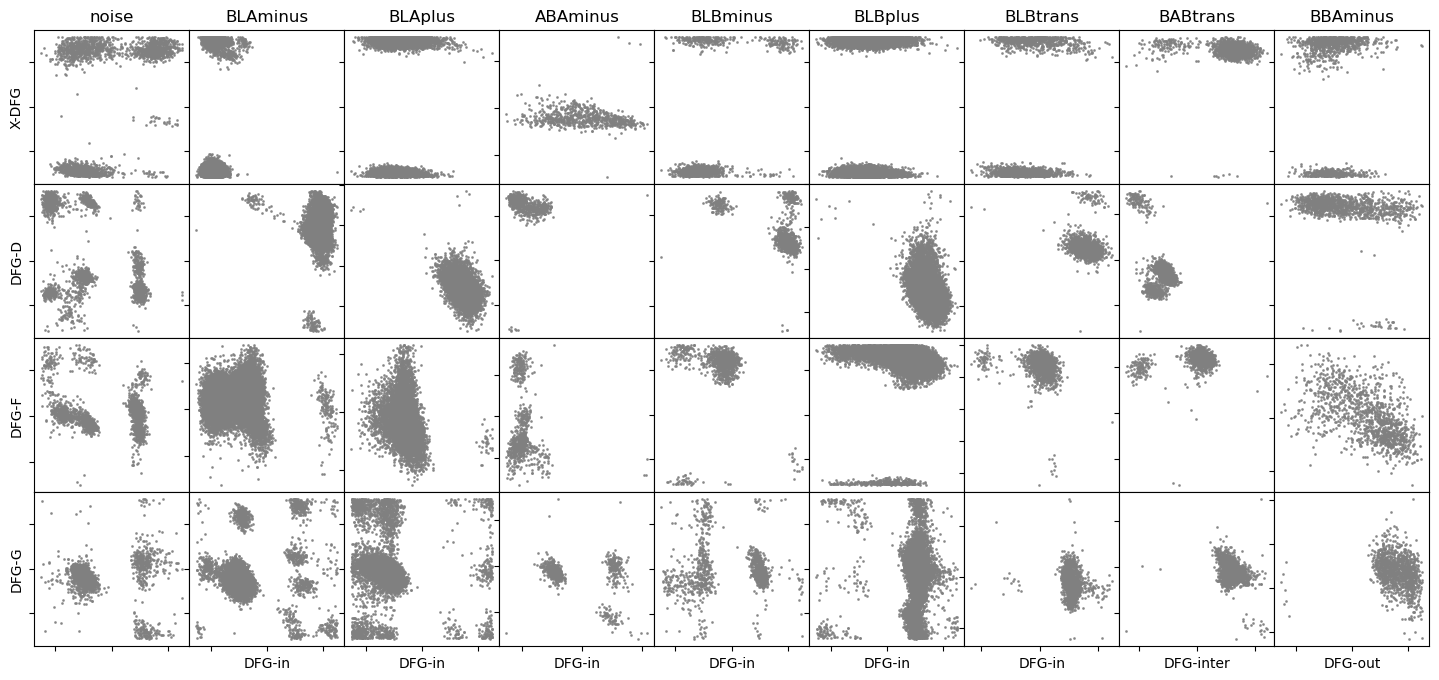

In [114]:
fig, axes = plt.subplots(nrows=4, ncols=9, figsize=(18, 8))

s = 1
alpha=0.8
c='grey'

cluster_labels = ['noise', 'BLAminus', 'BLAplus', 'ABAminus', 'BLBminus', 'BLBplus', 'BLBtrans', 'BABtrans', 'BBAminus']
dfg_labels = ['', 'DFG-in', 'DFG-in', 'DFG-in', 'DFG-in', 'DFG-in', 'DFG-in', 'DFG-inter', 'DFG-out']

for i, cluster in enumerate(cluster_labels):
    axes[0, i].set_title(cluster)
    axes[-1, i].set_xlabel(dfg_labels[i])
    if cluster == 'BBAminus':
        for j in range(4):
            axes[j, i].scatter(dfgout_dihed[out_dtraj == 0][:, 0+j*2], dfgout_dihed[out_dtraj == 0][:, 1+j*2], s=s, alpha=alpha, c=c)
    elif cluster == 'BABtrans':
        for j in range(4):
            axes[j, i].scatter(dfginter_dihed[inter_dtraj == 0][:, 0+j*2], dfginter_dihed[inter_dtraj == 0][:, 1+j*2], s=s, alpha=alpha, c=c)
    elif cluster == 'noise':
        for j in range(4):
            axes[j, i].scatter(dfgout_dihed[out_dtraj == -1][:, 0+j*2], dfgout_dihed[out_dtraj == -1][:, 1+j*2], s=s, alpha=alpha, c=c)
            axes[j, i].scatter(dfginter_dihed[inter_dtraj == -1][:, 0+j*2], dfginter_dihed[inter_dtraj == -1][:, 1+j*2], s=s, alpha=alpha, c=c)
            axes[j, i].scatter(dfgin_dihed[in_dtraj == -1][:, 0+j*2], dfgin_dihed[in_dtraj == -1][:, 1+j*2], s=s, alpha=alpha, c=c)
    else:
        for j in range(4):
            axes[j, i].scatter(dfgin_dihed[in_dtraj == i-1][:, 0+j*2], dfgin_dihed[in_dtraj == i-1][:, 1+j*2], s=s, alpha=alpha, c=c)

axes[0,0].set_ylabel('X-DFG')
axes[1,0].set_ylabel('DFG-D')
axes[2,0].set_ylabel('DFG-F')
axes[3,0].set_ylabel('DFG-G')

for ax in axes.flatten():
    ax.tick_params(labelbottom=False, labelleft=False)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(save_dir / 'dihed_sim_clusters.png', dpi=300, transparent=True)
plt.show()

Assign crystal structures (clusterd into spatial groups) to predefined cluster centroids.

In [5]:
crystal_in_dbdihed = crystal_dbdihed[crystal_clusters == 0]
in_dtraj = assign_dfg_dihed(crystal_in_dbdihed[:, [0,1,2,3,4,5,8]], spatial_group='dfg-in', centroids=None, noise_cutoff=1)
np.unique(in_dtraj, return_counts=True)

(array([0, 4]), array([14,  4]))

In [6]:
crystal_inter_dbdihed = crystal_dbdihed[crystal_clusters == 1]
inter_dtraj = assign_dfg_dihed(crystal_inter_dbdihed[:, [0,1,2,3,4,5,8]], spatial_group='dfg-inter', centroids=None, noise_cutoff=1)
np.unique(inter_dtraj, return_counts=True)

(array([0]), array([7]))

In [7]:
crystal_out_dbdihed = crystal_dbdihed[crystal_clusters == 2]
out_dtraj = assign_dfg_dihed(crystal_out_dbdihed[:, [0,1,2,3,4,5,8]], spatial_group='dfg-out', centroids=None, noise_cutoff=1)
np.unique(out_dtraj, return_counts=True)

(array([-1,  0]), array([13, 45]))

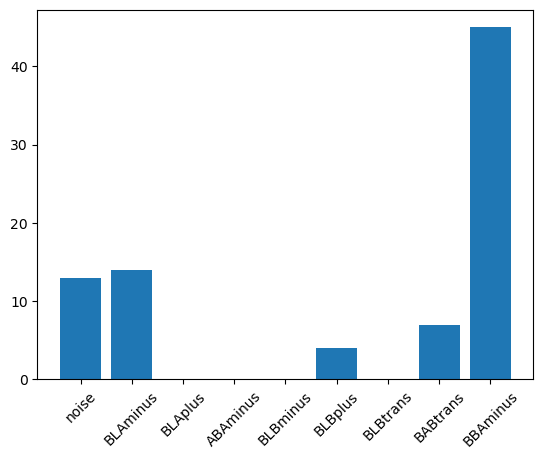

In [9]:
fig, ax = plt.subplots()
bincounts = [sum(in_dtraj==-1) + sum(inter_dtraj==-1) + sum(out_dtraj==-1),
             sum(in_dtraj==0),
             sum(in_dtraj==1),
             sum(in_dtraj==2),
             sum(in_dtraj==3),
             sum(in_dtraj==4),
             sum(in_dtraj==5),
             sum(inter_dtraj==0),
             sum(out_dtraj==0)]
cluster_labels = ['noise', 'BLAminus', 'BLAplus', 'ABAminus', 'BLBminus', 'BLBplus', 'BLBtrans', 'BABtrans', 'BBAminus']
ax.bar(cluster_labels, bincounts)
ax.xaxis.set_tick_params(rotation=45)
plt.savefig(save_dir, transparent=True, bbox_inches='tight', dpi=300)
plt.show()

In [26]:
def plot_crystal_dihed_pie(spatial_counts, dihed_counts, radius_size=0.35, figsize=(6,6), title='', fontsize=12, label=True, savedir=None):
    
    dihed_cluster_labels = ['noise', 'BLAminus', 'BLAplus', 'ABAminus', 'BLBminus', 'BLBplus', 'BLBtrans', 'noise', 'BABtrans', 'noise', 'BBAminus']
    spatial_cluster_labels = ['DFG-in', 'DFG-inter', 'DFG-out']
    
    outer_colors = [
    (128/255, 128/255, 128/255),  # Gray
    (235/255, 95/255, 70/255),    # Light Red
    (240/255, 146/255, 58/255),   # Flamebright
    (255/255, 214/255, 92/255),   # Light yellow
    (255/255, 188/255, 214/255),  # Light pink
    (210/255, 180/255, 140/255),  # Tan
    (196/255, 79/255, 108/255),   # Strawberry
    (128/255, 128/255, 128/255),  # Gray
    (25/255, 189/255, 85/255),    # Light Green
    (128/255, 128/255, 128/255),  # Gray
    (136/255, 75/255, 204/255)]   # Light Purple
    inner_colors = [
     (173/255, 35/255, 10/255),  # Red
     (28/225, 128/255, 65/255),  # Green
     (80/255, 29/255, 138/255)]  # Purple
    if label == True:
       filtered_spatial_cluster_labels = [label if count/sum(spatial_counts) >= 0.05 else '' for label, count in zip(spatial_cluster_labels, spatial_counts)]
       filtered_dihed_cluster_labels = [label if count/sum(sum(dihed_counts,[])) >= 0.05 else '' for label, count in zip(dihed_cluster_labels, sum(dihed_counts,[]))]
    else:
       filtered_spatial_cluster_labels = [''] * len(spatial_cluster_labels)
       filtered_dihed_cluster_labels = [''] * len(dihed_cluster_labels)

    explode = [0, 0.06] + [0] * (len(sum(dihed_counts, [])) - 2)
    fig, ax = plt.subplots(figsize=figsize)
 
    wedges_i, texts_i = ax.pie(spatial_counts, radius=1-radius_size, colors=inner_colors, 
           # labels=filtered_spatial_cluster_labels, textprops={'fontsize': fontsize, 'fontweight': 'bold'}, labeldistance=0.5, # Don't show the spatial labels
           wedgeprops=dict(width=radius_size, edgecolor='w'))

    wedges_o, texts_o = ax.pie(sum(dihed_counts,[]), radius=1, colors=outer_colors, explode=explode,
           labels=filtered_dihed_cluster_labels, textprops={'fontsize': fontsize, 'fontweight': 'bold'}, labeldistance=0.7,
           wedgeprops=dict(width=radius_size, edgecolor='w'))

    ax.set(aspect="equal")
    ax.text(0, 0, title, ha='center', va='center', fontsize=16, fontweight='bold')

    '''
    ax.legend(wedges_i, spatial_cluster_labels,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1),
              fontsize=18,
              markerscale=2)
    '''
    
    if savedir is not None:
        plt.savefig(savedir, transparent=True, bbox_inches='tight', dpi=300)
    plt.show()

    return None 

In [10]:
spatial_counts, dihed_counts = compute_dfg_assignment(dists=crystal_dbdist, diheds=crystal_dbdihed[:,[0,1,2,3,4,5,8]], dihed_cutoff=1.5)

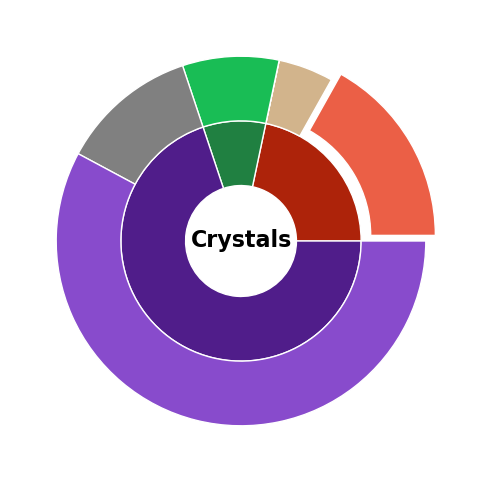

In [27]:
plot_crystal_dihed_pie(spatial_counts, dihed_counts, radius_size=0.35, figsize=(6,6), title='Crystals', label=False, fontsize=12, savedir=save_dir / 'crystal_dihed_pie_nolabel.png')

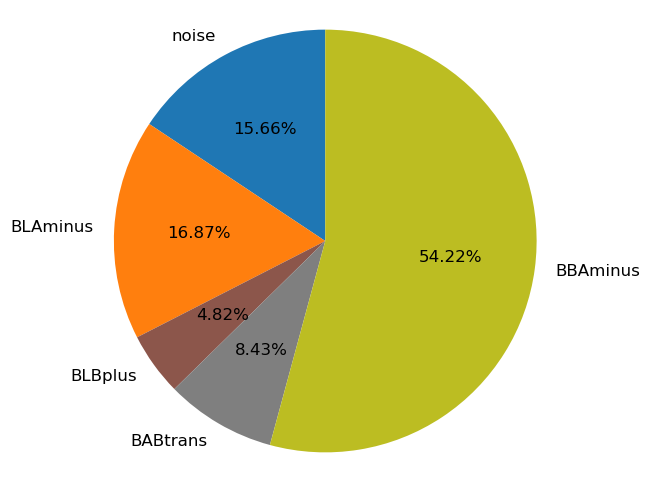

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))

filtered_labels = [label if count/sum(bincounts) >= 0.01 else '' for label, count in zip(cluster_labels, bincounts)]

ax.pie(bincounts, labels=filtered_labels, autopct=lambda p: f'{p:.2f}%' if p >= 1 else '', startangle=90, textprops={'fontsize': 12})
ax.axis('equal')  

plt.savefig(save_dir / 'dihed_crystal_cluster_pie.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

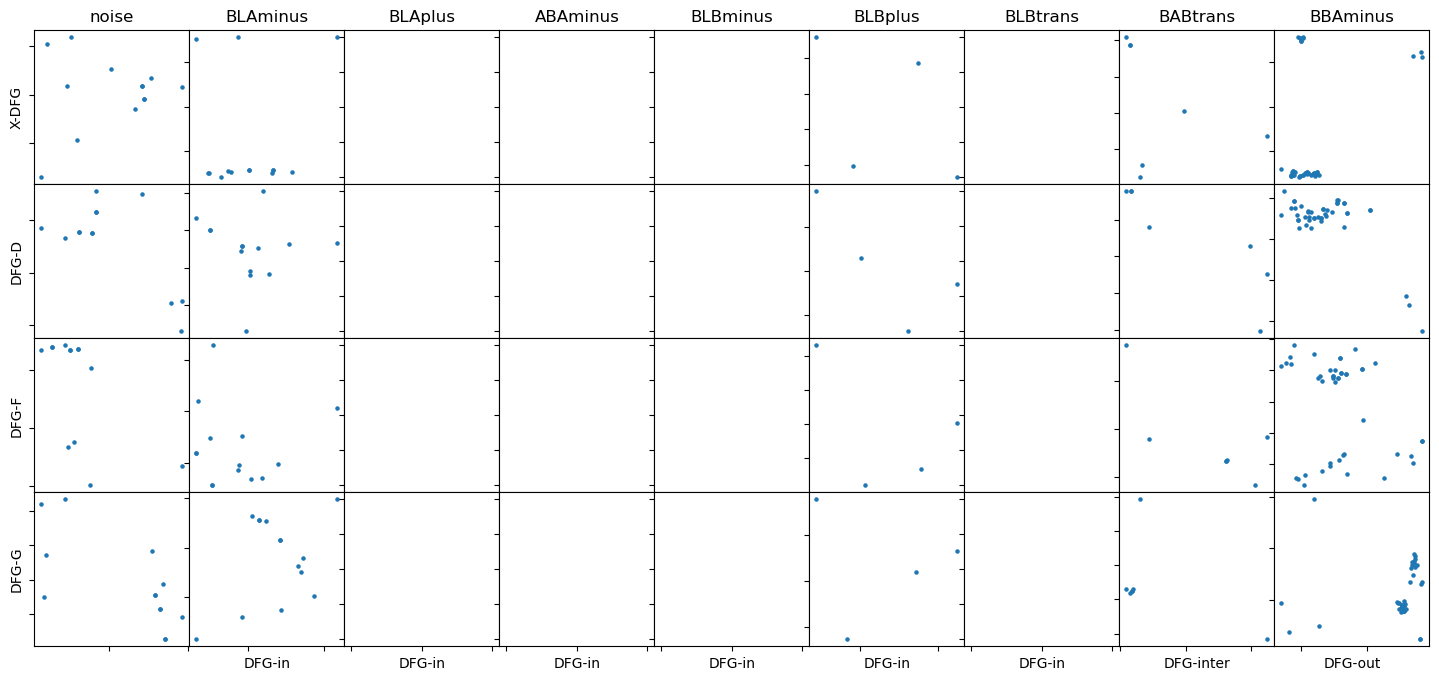

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=9, figsize=(18, 8))

s = 5
cluster_labels = ['noise', 'BLAminus', 'BLAplus', 'ABAminus', 'BLBminus', 'BLBplus', 'BLBtrans', 'BABtrans', 'BBAminus']
dfg_labels = ['', 'DFG-in', 'DFG-in', 'DFG-in', 'DFG-in', 'DFG-in', 'DFG-in', 'DFG-inter', 'DFG-out']

for i, cluster in enumerate(cluster_labels):
    axes[0, i].set_title(cluster)
    axes[-1, i].set_xlabel(dfg_labels[i])
    if cluster == 'BBAminus':
        for j in range(4):
            axes[j, i].scatter(crystal_out_dbdihed[out_dtraj == 0][:, 0+j*2], crystal_out_dbdihed[out_dtraj == 0][:, 1+j*2], s=s, alpha=1)
    elif cluster == 'BABtrans':
        for j in range(4):
            axes[j, i].scatter(crystal_inter_dbdihed[inter_dtraj == 0][:, 0+j*2], crystal_inter_dbdihed[inter_dtraj == 0][:, 1+j*2], s=s, alpha=1)
    elif cluster == 'noise':
        for j in range(4):
            axes[j, i].scatter(crystal_out_dbdihed[out_dtraj == -1][:, 0+j*2], crystal_out_dbdihed[out_dtraj == -1][:, 1+j*2], s=s, alpha=1)
            axes[j, i].scatter(crystal_inter_dbdihed[inter_dtraj == -1][:, 0+j*2], crystal_inter_dbdihed[inter_dtraj == -1][:, 1+j*2], s=s, alpha=1)
            axes[j, i].scatter(crystal_in_dbdihed[in_dtraj == -1][:, 0+j*2], crystal_inter_dbdihed[inter_dtraj == -1][:, 1+j*2], s=s, alpha=1)
    else:
        for j in range(4):
            axes[j, i].scatter(crystal_in_dbdihed[in_dtraj == i-1][:, 0+j*2], crystal_in_dbdihed[in_dtraj == i-1][:, 1+j*2], s=s, alpha=1)

axes[0,0].set_ylabel('X-DFG')
axes[1,0].set_ylabel('DFG-D')
axes[2,0].set_ylabel('DFG-F')
axes[3,0].set_ylabel('DFG-G')

for ax in axes.flatten():
    ax.tick_params(labelbottom=False, labelleft=False)


plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [35]:
d1 = [ftraj[:, 0] for ftraj in ftrajs_dist]
d2 = [ftraj[:, 1] for ftraj in ftrajs_dist]

In [68]:
dfg_in_samples = sample_frames_by_features([d1,d2], [[0.25,1],[1,2]], 20)
dfg_inter_samples = sample_frames_by_features([d1,d2], [[0.75,1.25],[0.25,0.6]], 20)
dfg_out_samples = sample_frames_by_features([d1,d2], [[1.3,2],[0.75,1.25]], 20)

In [111]:
save_samples(dfg_in_samples, traj_files, sample_dir / 'dfg_in_samples.pdb')
save_samples(dfg_inter_samples, traj_files, sample_dir / 'dfg_inter_samples.pdb')
save_samples(dfg_out_samples, traj_files, sample_dir / 'dfg_out_samples.pdb')

### Is there a DFG flipped trajectory in out simulations? 

In [11]:
dbdist, traj_mapping = get_data(trajlen_cutoff=1000, features=['dbdist'], ftraj_dir=Path(f'data_{protein}/ftrajs'))

Loading feature:  dbdist


100%|██████████| 3472/3472 [00:00<00:00, 14091.98it/s]

Loaded number of ftrajs: 1988


In [24]:
transition_ind = []
for i, traj in enumerate(dbdist):
    d1, d2 = traj[:, 0], traj[:, 1]
    is_open = np.logical_and(d1 < 0.9, d2 > 1)
    is_close = np.logical_and(d1 > 1.2, d1 < 1.2)
    if is_open.any() and is_close.any():
        transition_ind.append(i)
transition_ind

[]